APPROACH THAT WE USED IN THIS RESEARCH

In [1]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize



In [ ]:
train_dir = "../data/final/train"
test_dir  = "../data/final/test"

img_size = (224, 224)
batch_size = 16

image_files = [f for f in os.listdir(train_dir) if f.endswith(".tif")]

# Extract class labels from filenames (e.g., "001_1.tif" → class 001 → index 0)
class_labels = sorted(set(f.split("_")[0] for f in image_files))  # Unique classes
class_to_index = {label: i for i, label in enumerate(class_labels)}

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='sparse', color_mode='rgb'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False  # 🔒 ensure consistent ordering
)

Found 739 images belonging to 16 classes.


Found 189 images belonging to 16 classes.


In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-16]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax', 
                    kernel_regularizer=regularizers.l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)


# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,                 
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(
    filepath='best_fingerprint_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=60,
    callbacks=[lr_scheduler, early_stopping, checkpoint]
)

# Save model
model.save("best_fingerprint_model.h5")
print("\n✅ Model trained and saved as best_fingerprint_model.h5")

Epoch 1/60
47/47 [==============================] - ETA: 0s - loss: 3.2556 - accuracy: 0.1245
Epoch 1: val_accuracy improved from -inf to 0.29101, saving model to best_fingerprint_model.h5
47/47 [==============================] - 42s 509ms/step - loss: 3.2556 - accuracy: 0.1245 - val_loss: 2.9168 - val_accuracy: 0.2910 - lr: 1.0000e-05
Epoch 2/60
47/47 [==============================] - ETA: 0s - loss: 2.6601 - accuracy: 0.2720
Epoch 2: val_accuracy improved from 0.29101 to 0.46561, saving model to best_fingerprint_model.h5
47/47 [==============================] - 16s 343ms/step - loss: 2.6601 - accuracy: 0.2720 - val_loss: 2.3254 - val_accuracy: 0.4656 - lr: 1.0000e-05
Epoch 3/60
47/47 [==============================] - ETA: 0s - loss: 2.3062 - accuracy: 0.3640
Epoch 3: val_accuracy improved from 0.46561 to 0.53439, saving model to best_fingerprint_model.h5
47/47 [==============================] - 16s 342ms/step - loss: 2.3062 - accuracy: 0.3640 - val_loss: 2.0763 - val_accuracy: 0.53

In [4]:
print(test_gen.class_indices)

{'001': 0, '002': 1, '003': 2, '004': 3, '005': 4, '006': 5, '007': 6, '008': 7, '009': 8, '010': 9, '011': 10, '012': 11, '013': 12, '014': 13, '015': 14, '016': 15}


In [5]:
# Load the best model from checkpoint before evaluation
model = load_model("best_fingerprint_model.h5")

# Evaluate using the best model
loss, accuracy = model.evaluate(test_gen)
print(f"\n📊 Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")

12/12 [==============================] - 2s 126ms/step - loss: 0.7166 - accuracy: 0.9471

📊 Test Loss: 0.7166
✅ Test Accuracy: 0.9471


In [6]:
X_test = []
y_test = []

# Calculate number of steps needed to cover all test samples
steps = int(np.ceil(test_gen.samples / test_gen.batch_size))

# Collect only the required number of batches
for i in range(steps):
    x, y = next(test_gen)
    X_test.append(x)
    y_test.append(y)

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Predict
y_pred_probs = model.predict(X_test, batch_size=16)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report & Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

12/12 [==============================] - 1s 123ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9091    1.0000    0.9524        10
         1.0     0.9091    1.0000    0.9524        10
         2.0     1.0000    1.0000    1.0000        10
         3.0     0.9091    1.0000    0.9524        10
         4.0     0.8000    0.8000    0.8000        10
         5.0     0.9091    1.0000    0.9524        10
         6.0     1.0000    1.0000    1.0000        10
         7.0     1.0000    0.6000    0.7500         5
         8.0     0.8750    0.7000    0.7778        10
         9.0     0.9412    1.0000    0.9697        16
        10.0     0.9375    0.9375    0.9375        16
        11.0     1.0000    0.9375    0.9677        16
        12.0     0.9412    1.0000    0.9697        16
        13.0     1.0000    0.9375    0.9677        16
        14.0     1.0000    1.0000    1.0000         8
        15.0     1.0000    1.0000    1.0000        16

 

1/1 [==============================] - 0s 19ms/step


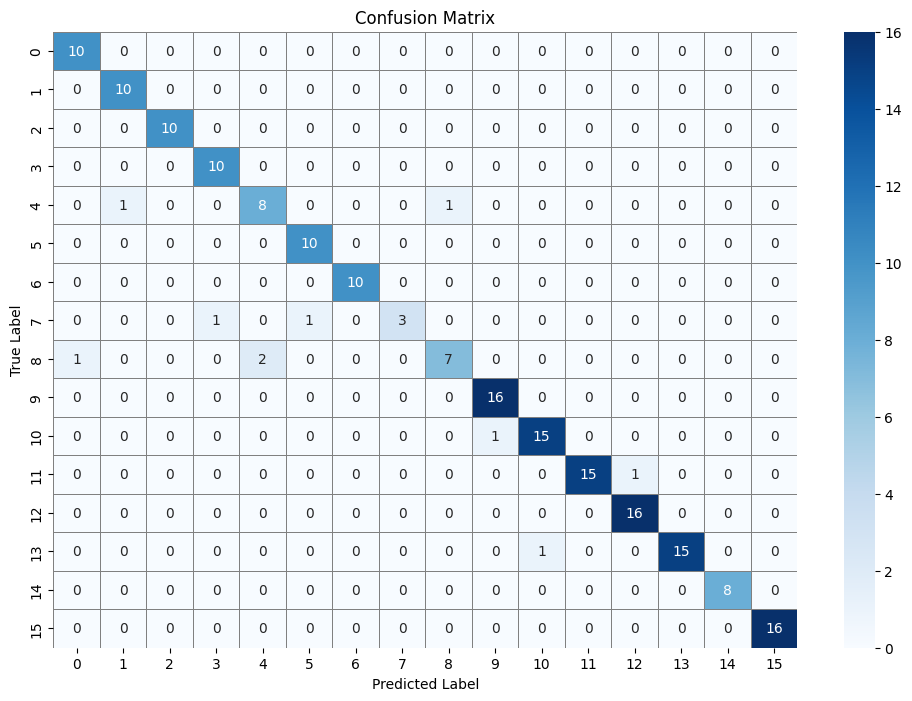

In [7]:
# Get true labels and predictions
y_true = []
y_pred = []

# Reset the generator before iterating
test_gen.reset()
steps = int(np.ceil(test_gen.samples / test_gen.batch_size))

for _ in range(steps):
    x_batch, y_batch = next(test_gen)

    # Handle one-hot encoded or integer labels
    if y_batch.ndim > 1:
        y_true.extend(np.argmax(y_batch, axis=1))
    else:
        y_true.extend(y_batch)

    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [8]:
report = classification_report(y_test, y_pred, output_dict=True)

# Macro averages (treats all classes equally)
precision_macro = report['macro avg']['precision']
recall_macro = report['macro avg']['recall']
f1_macro = report['macro avg']['f1-score']

# Weighted averages (accounts for class imbalance)
precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_weighted = report['weighted avg']['f1-score']

print(f"\nMacro Avg - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1 Score: {f1_macro:.4f}")
print(f"Weighted Avg - Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1 Score: {f1_weighted:.4f}")


Macro Avg - Precision: 0.9457, Recall: 0.9320, F1 Score: 0.9344
Weighted Avg - Precision: 0.9483, Recall: 0.9471, F1 Score: 0.9451


In [11]:
# One-hot encode true labels
y_test_onehot = label_binarize(y_test, classes=np.arange(model.output_shape[-1]))

# y_pred_probs: already predicted earlier like this
# y_pred_probs = model.predict(X_test)

# Multi-class ROC AUC using 'macro' average
roc_auc = roc_auc_score(y_test_onehot, y_pred_probs, average='macro', multi_class='ovr')

print(f"ROC AUC Score (macro): {roc_auc:.4f}")

ROC AUC Score (macro): 0.9975
